In [1]:
import sys
!pip install --user scipy

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import signal

Based on RBJ Audio EQ Cookbook (https://www.musicdsp.org/en/latest/Filters/197-rbj-audio-eq-cookbook.html)


In [58]:
# Specify audio parameters
Fs = 44100 # 192k is common with fancy ADCs/DACs
f0 = 880 # center frequency
# BW = 0.5 # 1 octaves of bandwidth?
# Might be better to specify Q to change the bandwidth, like in the EaganMatrix.
# Q < 1 increases the bandwidth, Q > 1 decreases the bandwidth (increases resonance? it's not a resonant filter?)
Q = 1

In [59]:
# Calculate w0 and alpha
w0 = 2*math.pi*f0/Fs
alpha = math.sin(w0)/(2*Q)

In [60]:
# Compute coefficients
# TODO: figure out why this works?
b0 = alpha
b1 = 0
b2 = -alpha
a0 = 1 + alpha
a1 = -2*math.cos(w0)
a2 = 1 - alpha

In [61]:
# Direct Form 1 implementation is
# y[n] = (b0/a0)*x[n] + (b1/a0)*x[n-1] + (b2/a0)*x[n-2] - (a1/a0)*y[n-1] - (a2/a0)*y[n-2]
# But for now we can use scipy tools to test the filter (using lfilter)
filter_num = np.array([b0, b1, b2])
filter_den = np.array([a0, a1, a2])

In [62]:
from IPython.display import Audio
from scipy.io.wavfile import read, write
from scipy.fft import fft

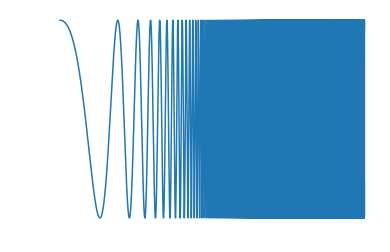

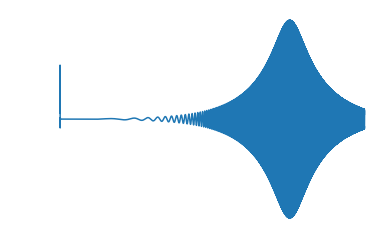

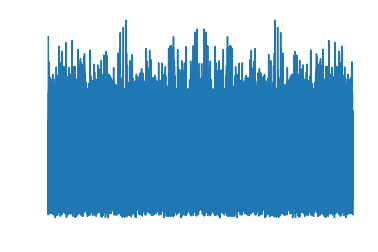

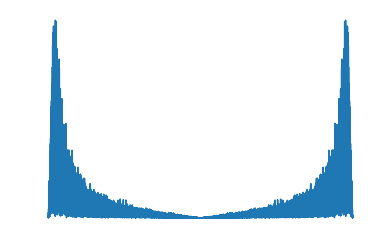

In [81]:


# Make some test data
# Also play the audio before and after
t = [i / Fs for i in range(2 * Fs)]
x = signal.chirp(t, 1, t[-1], 8000, method='logarithmic')

x_freq = np.arange(0, 8000, 8000/len(x))
plt.axis('off')
plt.plot(x)
#plt.title("raw chirp")

# Apply filter to chirp
y = signal.lfilter(filter_num, filter_den, x)

plt.figure()
plt.axis('off')

plt.plot(y)
#plt.title("Raw + filtered chirp")

filtered_samples = np.int16(y/np.max(np.abs(y)) * 32767)
write('filtered_chirp.wav', Fs, filtered_samples)
Audio('filtered_chirp.wav')

plt.figure()
# Try some white noise
# based on https://stackoverflow.com/questions/32237769/defining-a-white-noise-process-in-python
mean = 0
std = 1 
num_samples = Fs
samples = np.random.normal(mean, std, size=num_samples)

filtered_noise = signal.lfilter(filter_num, filter_den, samples)

noise_spec = fft(samples)
filtered_spec = fft(filtered_noise)
plt.axis('off')
plt.plot(np.abs(noise_spec))

plt.figure()
plt.axis('off')
plt.plot(np.abs(filtered_spec))
#plt.title("Filtered noise")


/home/wei/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


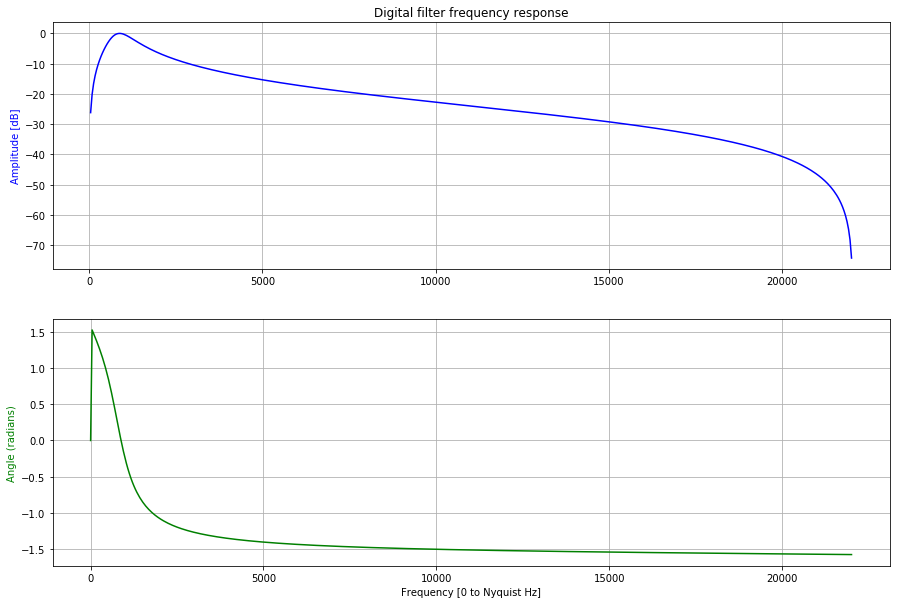

In [67]:
# Frequency analysis of filter
w, h = signal.freqz(filter_num, filter_den)

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.title('Digital filter frequency response')
plt.plot(w / np.pi * Fs / 2, 20*np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.grid()
plt.axis('tight')

plt.subplot(2,1,2)
angles = np.unwrap(np.angle(h))
plt.plot(w / np.pi * Fs / 2, angles, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')
plt.xlabel('Frequency [0 to Nyquist Hz]')
plt.show()

In [172]:
# Maybe do something a little more musical, like a sawtooth wave.
# This is more "engineer's" sawtooth than "musician's".

Fs, x = read('raw_sawtooth.wav')
Audio('raw_sawtooth.wav')




In [173]:
# Apply filter to chirp
y = signal.lfilter(filter_num, filter_den, x)

filtered_samples = np.int16(y/np.max(np.abs(y)) * 32767)
write('filtered_sawtooth.wav', Fs, filtered_samples)
Audio('filtered_sawtooth.wav')


In [ ]:
# Note for implementing on hardware.
# Take a look at the difference equation for this filter:
# y[n] = (b0/a0)*x[n] + (b1/a0)*x[n-1] + (b2/a0)*x[n-2] - (a1/a0)*y[n-1] - (a2/a0)*y[n-2]
# What do we do to calculate y[0] and y[1], when we don't have some of the "past" samples?
# We could maintain a frame buffer with this kind of numbering:
# n -2 -1  0  1 ... 512(or however many)
#
# All samples start out at 0. As new data is shifted in, some of it goes into the "-2" and "-1" places, which can be used to calculate
# y[0] in the current frame of audio data using the actual past data. This should protect against audio artefacts at the buffer boundaries
# that might occur if we zero those terms.